In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import h5py

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


from plot import PlotAx, STYLE_PATH
from util import rad2tbb, get_cris_full_train_data, get_range_index

%matplotlib inline

/home/cali/bin/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


获取文件

In [2]:
in_dir = '/home/cali/data/GapFilling/CRISFull/'
filenames = os.listdir(in_dir)
in_files = [os.path.join(in_dir, filename) for filename in filenames]
in_files.sort()

读取全部数据，并且去除无效数据

In [79]:
sample_count = None  # None 读取全部
all_X, all_Y = get_cris_full_train_data(in_files, count=sample_count)

_col_x = X.shape[1]

# 去除无效数据
XY = pd.concat([all_X, all_Y], axis=1)
XY = XY.astype('float32')
print(XY.shape)
XY[XY <= 0] = np.nan
XY = XY.dropna(axis=0)
print(XY.shape)

all_X = XY.iloc[:, :_col_x]
all_Y = XY.iloc[:, _col_x:]
del XY

(802200, 3369)
(687852, 3369)


设置测量通道和预测通道的波数范围

In [69]:
FREQUENCY_INTERVAL = 0.625
RANGES_ALL_X = [(650., 1095.), (1210., 1750.), (2155., 2550.), ]
RANGES_ALL_Y = [(1095.625, 1209.375), (1750.625, 2154.375), (2550.625, 2755.), ]

# ranges_X = [(650., 1095.), (1210., 1750.), (2155., 2550.), ]
# ranges_X = [(650., 1095), ]
ranges_X = [(1210., 1750), ]
# ranges_X = [(2155., 2550.), ]

# ranges_Y = [(1095.625, 1209.375), (1750.625, 2154.375), (2550.625, 2755.), ]
# ranges_Y = [(1095.625, 1209.375), ]
ranges_Y = [(1750.625, 2154.375), ]
# ranges_Y = [(2550.625, 2755.), ]

In [70]:
# 制作绘图用的X轴数据
wavenumber_X = []
for s, e in ranges_X:
    wavenumber_X = np.append(wavenumber_X, np.arange(s, e + FREQUENCY_INTERVAL, FREQUENCY_INTERVAL))
wavenumber_Y = []
for s, e in ranges_Y:
    wavenumber_Y = np.append(wavenumber_Y, np.arange(s, e + FREQUENCY_INTERVAL, FREQUENCY_INTERVAL))
    
# 制作绘图用的X轴数据的index
from util import get_range_index
index_X = get_range_index(ranges_X, step=FREQUENCY_INTERVAL)
index_Y = get_range_index(ranges_Y, step=FREQUENCY_INTERVAL)
print(index_X)
print(index_Y)

[[0, 865]]
[[0, 647]]


In [71]:
X = None
Y = None

index_XY = get_range_index(ranges_Y, step=FREQUENCY_INTERVAL)

for _s, _e in index_X:
    _X = all_X.iloc[:, _s:_e]
    if X is None:
        X = _X
    else:
        X = pd.concat([X, _X], axis=1)
for _s, _e in index_Y:
    _Y = all_Y.iloc[:, _s:_e]
    if Y is None:
        Y = _Y
    else:
        Y = pd.concat([Y, _Y], axis=1)

In [72]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 687852 entries, 0 to 802198
Columns: 865 entries, 0 to 864
dtypes: float32(865)
memory usage: 2.2 GB


In [73]:
Y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 687852 entries, 0 to 802198
Columns: 647 entries, 0 to 646
dtypes: float32(647)
memory usage: 1.7 GB


In [74]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, random_state = 42, test_size=0.2)
train_X = pd.DataFrame(train_X)
test_X = pd.DataFrame(test_X)
train_Y = pd.DataFrame(train_Y)
test_Y = pd.DataFrame(test_Y)

In [75]:
lin_reg = LinearRegression(normalize=False)
lin_reg.fit(train_X, train_Y)

predictions_Y = lin_reg.predict(test_X)

print(mean_absolute_error(test_Y, predictions_Y))

0.0022338834


绘制 TBB Bias Mean 和 TBB Bias Std

In [76]:
# test_rad = test_Y
# prediction_rad = predictions_Y
# prediction_rad = pd.DataFrame(prediction_rad)

# rad_col = test_rad.shape[1]

# all_rad = pd.concat((test_rad, prediction_rad), axis=1)
# print(all_rad.shape)
# all_rad[all_rad<=0] = np.nan
# all_rad = all_rad.dropna(axis=0)
# print(all_rad.shape)

# test_rad = all_rad.iloc[:, :rad_col]
# prediction_rad = all_rad.iloc[:, rad_col:]

In [77]:
test_rad = np.array(test_Y)
prediction_rad = np.array(predictions_Y)

test_tbb = rad2tbb(test_rad, wavenumber_Y)
prediction_tbb = rad2tbb(prediction_rad, wavenumber_Y)

bias_tbb = prediction_tbb - test_tbb

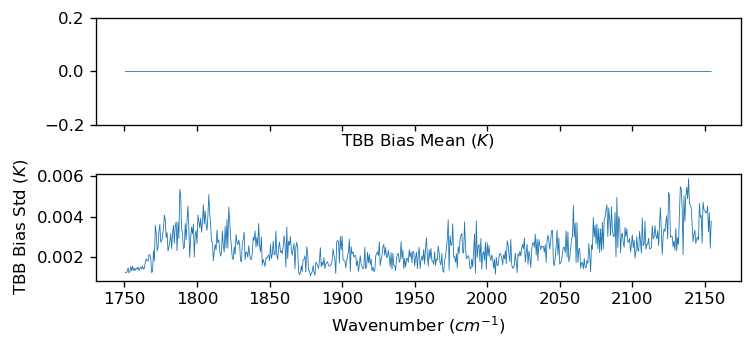

In [78]:
fig = plt.figure(figsize=(6.4, 3), dpi=120)
ax1 = plt.subplot2grid((2, 1), (0, 0))
ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

ax1.plot(wavenumber_Y, bias_tbb.mean(axis=0), lw=0.5)
ax1.set_ylim(-0.2, 0.2)
ax1.set_xlabel('TBB Bias Mean $(K)$')
ax2.plot(wavenumber_Y, bias_tbb.std(axis=0), lw=0.5)
# ax2.set_ylim(0, 1)
ax2.set_xlabel('Wavenumber $(cm^{-1})$')
ax2.set_ylabel('TBB Bias Std $(K)$')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.tight_layout()